<a href="https://colab.research.google.com/github/akshaygrao77/DeepLearning-Assignment2/blob/main/PART_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
#Import and install required libraries
import os
import glob
import tensorflow as tf

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras.callbacks import History
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
!pip install wandb
import wandb
from wandb.keras import WandbCallback
import os
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [65]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:

#Unzip and load file data file onto server, then delete zip file for optimizing performance
zip_path = "drive/MyDrive/nature_12K.zip"
!cp "{zip_path}" .
!unzip -q nature_12K.zip
!rm nature_12K.zip

replace inaturalist_12K/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [67]:
train_dir='inaturalist_12K/train/'
test_dir='inaturalist_12K/val/'
categories=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

In [68]:
path_train_data = os.getcwd()+"/inaturalist_12K/train"
path_test_data = os.getcwd()+"/inaturalist_12K/val"

width, height = 200, 200

batch_size = 128

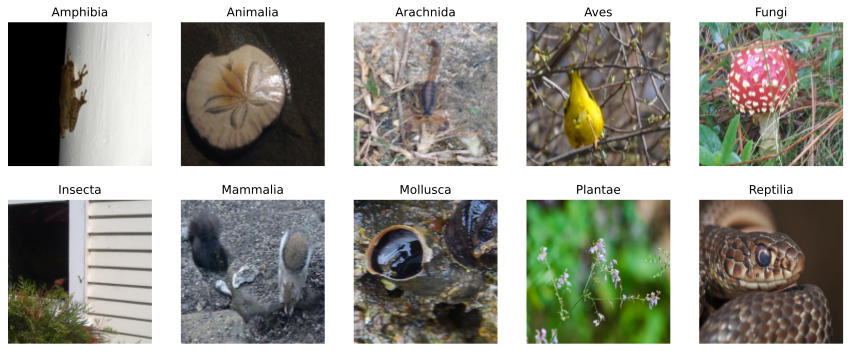

In [69]:
#visualizing images 
fig = plt.figure(figsize=(15,6))
rows,columns=2,5
i=1
for category in categories:
  dir=os.path.join(train_dir,category)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(300,300))
    fig.add_subplot(rows,columns,i)
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(category)
    i+=1   
    break

In [70]:
wandb.init(project="DLAssignment2", entity='cs21s002-ee21s113-dlassignment-1')

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


In [71]:
def get_model(filter_list=[64, 32, 48, 32, 32], dropout=0.2, batch_norm=False, dense_layer_size=512, conv_activations=["relu", "relu", "relu", "relu", "relu"], dense_layer_activation="relu", output_activation="softmax"):
    
    model = Sequential()

    for i in range(5):
        model.add(Conv2D(filter_list[i], (3, 3), input_shape=(200,200,3), padding="same"))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Activation(conv_activations[i]))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_layer_size))
    model.add(Dropout(dropout))
    model.add(Activation(dense_layer_activation))
    model.add(Dense(10))
    model.add(Activation(output_activation))

    return model;

In [72]:
def get_dataset_generators(train_data_aug=False):
    if train_data_aug:
        train_idg = ImageDataGenerator(
            rescale=1. /255,
            validation_split=0.1,               #10% is to be kept aside
            horizontal_flip=True,
            vertical_flip=False,
            rotation_range=15,
            shear_range=0.1,
            zoom_range=0.1,
            width_shift_range=0.2,
            height_shift_range=0.2
        )
    else:
        train_idg = ImageDataGenerator(
            rescale=1. /255,
            validation_split=0.1                 #10% is to be kept aside
        )
    
    test_idg = ImageDataGenerator(
            rescale=1. /255
        )
    
    print(f"{path_train_data}")
    train_generator = train_idg.flow_from_directory(
        path_train_data,
        batch_size=batch_size,
        target_size=(width, height),
        subset='training',
        class_mode='categorical'
    )

    val_generator = train_idg.flow_from_directory(
        path_train_data,
        batch_size=batch_size,
        target_size=(width, height),
        subset='validation',
        class_mode='categorical'
    )

    print(f"{path_test_data}")
    test_generator = test_idg.flow_from_directory(
        path_test_data,
        batch_size=batch_size, 
        target_size=(width, height)
    )
    
    return train_generator, val_generator, test_generator

In [73]:
default_config = {
        "filter_list":[64, 32, 48, 32, 32], 
        "dropout":0.2, 
        "batch_norm":False, 
        "dense_layer_size":512,
        "epochs": 10,
        "lr": 0.001,
        "train_data_aug":False
    }

#Keras callback    
history = History()

In [74]:
def run():
    # Create a MirroredStrategy.
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
    else:  # use default strategy
        strategy = tf.distribute.get_strategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

    wandb.init(config=default_config, magic=True, project='DLAssignment2', entity='cs21s002-ee21s113-dlassignment-1')
    config = wandb.config
    run_name = str(config).replace("{", "").replace("}","").replace(":","-")
    wandb.run.name = run_name

    # Open a strategy scope and create the model
    with strategy.scope():
        model = get_model(config.filter_list, config.dropout, config.batch_norm, config.dense_layer_size)

    plot_model(model)

    model.summary()

    train_generator, val_generator, test_generator = get_dataset_generators(config.train_data_aug)

    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(config.lr), metrics="categorical_accuracy")

    model.fit(train_generator, epochs=config.epochs, validation_data=val_generator, callbacks=[WandbCallback(), history])

    model.evaluate(test_generator)

    model.save(f'{run_name.replace(",","-")}.h5')  # creates a HDF5 file 'my_model.h5'

In [75]:
sweep_config = {
    "name": "Assignment 2 - alpha",
    "metric": "categorical_accuracy",
    "method": "random",
    "project": 'Assignment 2',
    "parameters": {
        "filter_list": {
            "values": [[64, 64, 48, 32, 32], [128, 64, 48, 32, 32], [32, 32, 32, 32, 32], [64, 64, 64, 64, 64]]
        },
        "dropout": {
            "values": [0.2, 0.3, 0.5]
        },
        "batch_norm": {
            "values": [True, False]
        },
        "dense_layer_size": {
            "values": [512, 1024]
        },
        "train_data_aug": {
            "values": [True, False]
        },
        "epochs": {
            "values": [1, 5, 7]
        },
        "lr": {
            "values": [0.001, 0.0001, 0.00001, 0.01]
        },
        
    }
}

In [76]:
sweep_id = wandb.sweep(sweep_config, project='DLAssignment2', entity='cs21s002-ee21s113-dlassignment-1')

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. 'categorical_accuracy' is not of type 'object'


Create sweep with ID: 7woa9io0
Sweep URL: https://wandb.ai/cs21s002-ee21s113-dlassignment-1/DLAssignment2/sweeps/7woa9io0


In [ ]:
wandb.agent(sweep_id, function=run, project='DLAssignment2', entity='cs21s002-ee21s113-dlassignment-1')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 8bwwyedq with config:
wandb: 	batch_norm: False
wandb: 	dense_layer_size: 1024
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	filter_list: [32, 32, 32, 32, 32]
wandb: 	lr: 1e-05
wandb: 	train_data_aug: True


Number of devices: 1


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 activation (Activation)     (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                    

In [ ]:
sweep_config_v2 = {
    "name": "Assignment 2 - beta",
    "metric": "categorical_accuracy",
    "method": "random",
    "project": 'Assignment 2',
    "parameters": {
        "filter_list": {
            "values": [[64, 64, 64, 64, 64]]
        },
        "dropout": {
            "values": [0.2, 0.3, 0.5]
        },
        "batch_norm": {
            "values": [False]
        },
        "dense_layer_size": {
            "values": [1024]
        },
        "train_data_aug": {
            "values": [True]
        },
        "epochs": {
            "values": [10]
        },
        "lr": {
            "values": [0.001, 0.0001]
        },
        
    }
}

In [ ]:
def test():
    # Create a MirroredStrategy.
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
    else:  # use default strategy
        strategy = tf.distribute.get_strategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

    wandb.init(config=default_config, magic=True, project='DLAssignment2', entity='cs21s002-ee21s113-dlassignment-1')
    config = wandb.config
    run_name = str(config).replace("{", "").replace("}","").replace(":","-")
    wandb.run.name = run_name

    # Open a strategy scope and create the model
    with strategy.scope():
        model = get_model(config.filter_list, config.dropout, config.batch_norm, config.dense_layer_size)

    plot_model(model, to_file="temp.png")

    model.summary()

    train_generator, val_generator, test_generator = get_dataset_generators(config.train_data_aug)

    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(config.lr), metrics="categorical_accuracy")

    model.fit(train_generator, epochs=config.epochs, validation_data=test_generator, callbacks=[WandbCallback()])

In [ ]:
sweep_id = wandb.sweep(sweep_config_v2, project='DLAssignment2', entity='cs21s002-ee21s113-dlassignment-1')

In [ ]:
wandb.agent(sweep_id, function=test, project='DLAssignment2', entity='cs21s002-ee21s113-dlassignment-1')

In [ ]:
# Create a MirroredStrategy.
if tf.config.list_physical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy()
else:  # use default strategy
    strategy = tf.distribute.get_strategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope and create the model
with strategy.scope():
    model = get_model([128, 64, 64, 48, 64], 0.2, True, 1024)

plot_model(model)

model.summary()

train_generator, val_generator, test_generator = get_dataset_generators(True)

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(0.001), metrics="accuracy")

model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[history])

model.evaluate(test_generator)

In [ ]:
classes = {0: 'Amphibia', 1: 'Animalia', 2: 'Arachnida', 3: 'Aves', 4: 'Fungi', 5: 'Insecta', 6: 'Mammalia', 7: 'Mollusca', 8: 'Plantae', 9: 'Reptilia'}

images, labels = test_generator.next()
predictions = model(images)

In [ ]:
count = [0]*10
images_list = []
f, a = plt.subplots(nrows=10, ncols=3, figsize=(15,50))
for i, img in enumerate(images):
    class_label = np.argmax(labels[i], axis=0)
    pred_label = np.argmax(predictions[i], axis=0)
    if count[class_label] < 3:
        a[class_label, count[class_label]].imshow(img)
        a[class_label, count[class_label]].axis('off')
        ttl = "Actual: " + classes[class_label] + "\nPredicted: " + classes[pred_label]
        a[class_label, count[class_label]].set_title(ttl)
        count[class_label] += 1
        images_list.append((img, ttl))
plt.show()

In [ ]:
layer_outputs = [layer.output for layer in model.layers]

activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(images[55:56])
first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 127])

In [ ]:
plt.figure(figsize=(20,40))
for d in range(128):
  plt.subplot(16, 8, d+1)
  plt.imshow(first_layer_activation[0, :, :, d])
#   wandb.log({"Filters": wandb.Image(first_layer_activation[0, :, :, d])})
# plt.savefig("filters.png")
plt.show()

In [ ]:
filters_img = Image.open("filters.png") 
wandb.log({"Filters of Layer 1": wandb.Image(filters_img)})

In [ ]:
model_upto_conv5 = tf.keras.models.Model([model.inputs],[model.get_layer("conv2d_29").output]) #conv2d_29
@tf.custom_gradient
def guidedRelU(x):
    def grad(dy):
        return tf.cast(dy>0, tf.float32) * tf.cast(x>0, tf.float32) * dy
    return tf.nn.relu(x), grad

for layer in model.layers[1:]:
    if hasattr(layer, 'activation') and layer.activation==tf.keras.activations.relu:
        layer.activation = guidedRelU

f, a = plt.subplots(10, 2, figsize=(10, 40))
inputs = tf.convert_to_tensor(images[55:65], dtype=tf.float32)

for i in range(10):

    with tf.GradientTape() as tape:
        input = tf.expand_dims(inputs[i], 0)
        tape.watch(input)
        output = model_upto_conv5(input)[0]
    
    gradients = tape.gradient(output,input)[0]

    a[i][0].set_title("Original")
    a[i][0].imshow(inputs[i])
    a[i][1].set_title("Guided backpropagation")
    a[i][1].imshow(gradients)
wandb.log({"Guided Backpropagation": wandb.Image(f)})
f.savefig("guided_backprop.png")
plt.show()
